# Resume Selector with Naive Bayes Classifiers

***Goal:***
- To predict whether a given resume text is flagged or not.

***Result:***
- Overall accuracy 0.72 (total number of data 125)
- f1-score for not flagged 0.81 and flagged 0.46 (number of not flagged data 92 and number of flagged data 33)

***Table of Content:***

0. Import Libearies and Dataset
1. Perform Exploratory Data Analysis
2. Perform Data Cleaning
3. Visualize Cleaned Up Dataset
4. Prepare The Data by Performing Tokenization and Padding
5. Build and Train The Model
6. Assess Trained Model Performance

<img src="PPT/Naive_Bayes_Classifiers.png" width="1000">

Source: https://www.coursera.org/projects/resume-selector-using-naive-bayes by Ryan Ahmed - Adjunct Professor

### 0. Import Libearies and Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.metrics import classification_report, confusion_matrix

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False) 

In [4]:
# load the data
resume_df = pd.read_csv('data/resume.csv', encoding = 'latin-1')

In [5]:
resume_df

,resume_id,class,resume_text
0,resume_1,not_flagged,\rCustomer Service Supervisor/Tier - Isabella ...
1,resume_2,not_flagged,\rEngineer / Scientist - IBM Microelectronics ...
2,resume_3,not_flagged,\rLTS Software Engineer Computational Lithogra...
3,resume_4,not_flagged,TUTOR\rWilliston VT - Email me on Indeed: ind...
4,resume_5,flagged,\rIndependent Consultant - Self-employed\rBurl...
...,...,...,...
120,resume_121,not_flagged,\rBrattleboro VT - Email me on Indeed: indeed....
121,resume_122,not_flagged,\rResearch and Teaching Assistant - University...
122,resume_123,not_flagged,\rMedical Coder - Highly Skilled - Entry Level...
123,resume_124,flagged,\rWaterbury VT - Email me on Indeed: indeed.co...


In [6]:
# data containing resume
resume_df = resume_df[['resume_text', 'class' ]]
resume_df

,resume_text,class
0,\rCustomer Service Supervisor/Tier - Isabella ...,not_flagged
1,\rEngineer / Scientist - IBM Microelectronics ...,not_flagged
2,\rLTS Software Engineer Computational Lithogra...,not_flagged
3,TUTOR\rWilliston VT - Email me on Indeed: ind...,not_flagged
4,\rIndependent Consultant - Self-employed\rBurl...,flagged
...,...,...
120,\rBrattleboro VT - Email me on Indeed: indeed....,not_flagged
121,\rResearch and Teaching Assistant - University...,not_flagged
122,\rMedical Coder - Highly Skilled - Entry Level...,not_flagged
123,\rWaterbury VT - Email me on Indeed: indeed.co...,flagged


### 1. Perform Exploratory Data Analysis

In [7]:
# obtain dataframe information
resume_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   resume_text  125 non-null    object
 1   class        125 non-null    object
dtypes: object(2)
memory usage: 2.1+ KB


In [8]:
# check for null values
resume_df.isnull().sum()

resume_text    0
class          0
dtype: int64

In [9]:
resume_df['class'].value_counts()

not_flagged    92
flagged        33
Name: class, dtype: int64

In [10]:
resume_df['class'] = resume_df['class'].apply(lambda x:1 if x == 'flagged' else 0)    # if find x under the column 'class' with == 'flagged', then x return 1, else return 0

resume_df

/var/folders/vs/qjltbn7d2437nc29s6lk_cvw0000gn/T/ipykernel_2674/3955050886.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resume_df['class'] = resume_df['class'].apply(lambda x:1 if x == 'flagged' else 0)    # if find x under the column 'class' with == 'flagged', then x return 1, else return 0


,resume_text,class
0,\rCustomer Service Supervisor/Tier - Isabella ...,0
1,\rEngineer / Scientist - IBM Microelectronics ...,0
2,\rLTS Software Engineer Computational Lithogra...,0
3,TUTOR\rWilliston VT - Email me on Indeed: ind...,0
4,\rIndependent Consultant - Self-employed\rBurl...,1
...,...,...
120,\rBrattleboro VT - Email me on Indeed: indeed....,0
121,\rResearch and Teaching Assistant - University...,0
122,\rMedical Coder - Highly Skilled - Entry Level...,0
123,\rWaterbury VT - Email me on Indeed: indeed.co...,1


### 2. Perform Data Cleaning

In [12]:
resume_df['resume_text'] = resume_df['resume_text'].apply(lambda x: x.replace('\r', ''))
resume_df

/var/folders/vs/qjltbn7d2437nc29s6lk_cvw0000gn/T/ipykernel_2674/3883194643.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resume_df['resume_text'] = resume_df['resume_text'].apply(lambda x: x.replace('\r', ''))


,resume_text,class
0,Customer Service Supervisor/Tier - Isabella Ca...,0
1,Engineer / Scientist - IBM Microelectronics Di...,0
2,LTS Software Engineer Computational Lithograph...,0
3,TUTORWilliston VT - Email me on Indeed: indee...,0
4,Independent Consultant - Self-employedBurlingt...,1
...,...,...
120,Brattleboro VT - Email me on Indeed: indeed.co...,0
121,Research and Teaching Assistant - University o...,0
122,Medical Coder - Highly Skilled - Entry LevelSu...,0
123,Waterbury VT - Email me on Indeed: indeed.com/...,1


In [13]:
# download nltk packages
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/hoikinyu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
# download nltk packages
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hoikinyu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
# Get additional stopwords from nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'email', 'com'])

In [16]:
# Remove stop words and remove words with 2 or less characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)
            
    return ' '.join(result)

In [17]:
# Cleaned text
resume_df['cleaned'] = resume_df['resume_text'].apply(preprocess)

In [18]:
resume_df

,resume_text,class,cleaned
0,Customer Service Supervisor/Tier - Isabella Ca...,0,customer service supervisor tier isabella cata...
1,Engineer / Scientist - IBM Microelectronics Di...,0,engineer scientist ibm albert gregoritsch ecaw...
2,LTS Software Engineer Computational Lithograph...,0,lts software engineer computational lithograph...
3,TUTORWilliston VT - Email me on Indeed: indee...,0,tutorwilliston alec schwartz awork college bio...
4,Independent Consultant - Self-employedBurlingt...,1,independent consultant self alex reutter fefwo...
...,...,...,...
120,Brattleboro VT - Email me on Indeed: indeed.co...,0,brattleboro bcc skilled presenter trainer micr...
121,Research and Teaching Assistant - University o...,0,research teaching assistant university cdd gra...
122,Medical Coder - Highly Skilled - Entry LevelSu...,0,medical coder highly skilled entry levelsudbur...
123,Waterbury VT - Email me on Indeed: indeed.com/...,1,waterbury bec fcwilling relocate work employer...


### 3. Visualize Cleaned Up Dataset

/Users/hoikinyu/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='class', ylabel='count'>

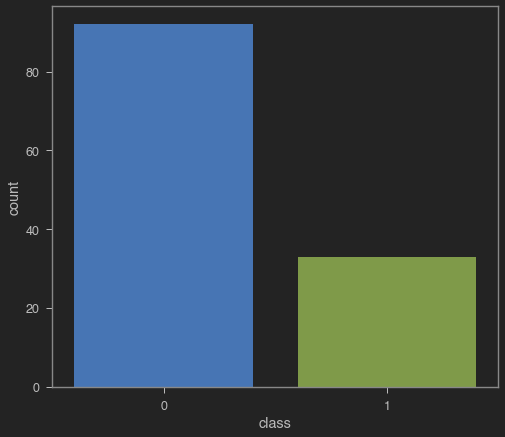

In [20]:
# Plot the counts of flagged vs not flagged
sns.countplot(resume_df['class'], label = 'Count Plot')

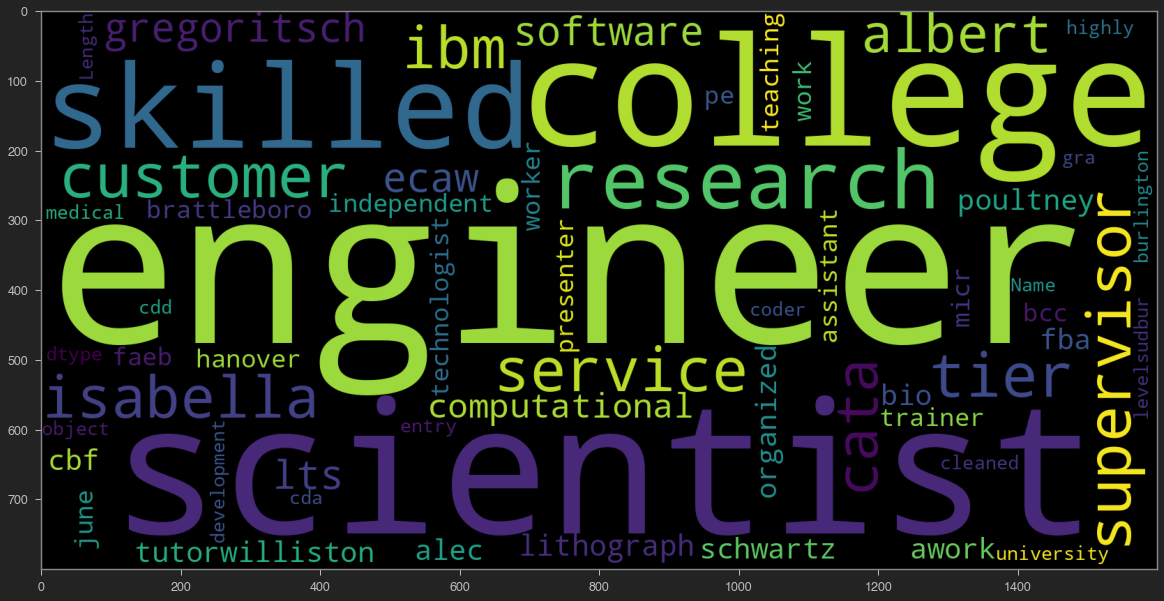

In [21]:
# plot the word cloud for text that is flagged
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000, width = 1600, height = 800, stopwords = stop_words).generate(str(resume_df[resume_df['class'] == 0].cleaned))
plt.imshow(wc)

### 4. Prepare The Data by Applying Count Vectorizer

In [22]:
# CountVectorizer example
from sklearn.feature_extraction.text import CountVectorizer
sample_data = ['This is the first document.','This document is the second document.','And this is the third one.','Is this the first document?', 'You and me']

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(sample_data)

In [23]:
print(X[1])

  (0, 9)	1
  (0, 3)	1
  (0, 7)	1
  (0, 1)	2
  (0, 6)	1


In [24]:
print(vectorizer.get_feature_names())

['and', 'document', 'first', 'is', 'me', 'one', 'second', 'the', 'third', 'this', 'you']


/Users/hoikinyu/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [25]:
print(X.toarray())

[[0 1 1 1 0 0 0 1 0 1 0]
 [0 2 0 1 0 0 1 1 0 1 0]
 [1 0 0 1 0 1 0 1 1 1 0]
 [0 1 1 1 0 0 0 1 0 1 0]
 [1 0 0 0 1 0 0 0 0 0 1]]


In [26]:
# Applying CountVectorier to the cleaned text
vectorizer = CountVectorizer()
countvectorizer = vectorizer.fit_transform(resume_df['cleaned'])

In [27]:
print(vectorizer.get_feature_names())

['aaalac', 'aabb', 'aac', 'aacn', 'aacr', 'aacrjournals', 'aakeroõ_y', 'aanpcp', 'aaron', 'abbott', 'abdomen', 'abdominal', 'abdul', 'aberdeen', 'abi', 'abilities', 'ability', 'abiotic', 'able', 'abnormal', 'aboard', 'abosalem', 'abraham', 'abreast', 'abs', 'absence', 'absorbance', 'abstract', 'abstracta', 'abstractdisease', 'abstracted', 'abstractin', 'abstracts', 'abualrub', 'abundance', 'abureehan', 'abuse', 'abusiness', 'academia', 'academic', 'academics', 'academy', 'acaeefbc', 'accelerated', 'accept', 'acceptability', 'acceptable', 'acceptance', 'accepted', 'accepting', 'access', 'accessibility', 'accessible', 'accession', 'accident', 'accidents', 'accolateî', 'accommodations', 'accomplished', 'accomplishment', 'accomplishments', 'accord', 'accordance', 'according', 'accordingly', 'accords', 'account', 'accountability', 'accountable', 'accounted', 'accounting', 'accounts', 'accreditation', 'accredited', 'accrual', 'accumulation', 'accuracy', 'accurate', 'accurately', 'accustomed'

In [28]:
print(countvectorizer.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### 5. Train Naive Bayes Classifier Model

In [30]:
X = countvectorizer

X.shape

(125, 11314)

In [31]:
resume_df

,resume_text,class,cleaned
0,Customer Service Supervisor/Tier - Isabella Ca...,0,customer service supervisor tier isabella cata...
1,Engineer / Scientist - IBM Microelectronics Di...,0,engineer scientist ibm albert gregoritsch ecaw...
2,LTS Software Engineer Computational Lithograph...,0,lts software engineer computational lithograph...
3,TUTORWilliston VT - Email me on Indeed: indee...,0,tutorwilliston alec schwartz awork college bio...
4,Independent Consultant - Self-employedBurlingt...,1,independent consultant self alex reutter fefwo...
...,...,...,...
120,Brattleboro VT - Email me on Indeed: indeed.co...,0,brattleboro bcc skilled presenter trainer micr...
121,Research and Teaching Assistant - University o...,0,research teaching assistant university cdd gra...
122,Medical Coder - Highly Skilled - Entry LevelSu...,0,medical coder highly skilled entry levelsudbur...
123,Waterbury VT - Email me on Indeed: indeed.com/...,1,waterbury bec fcwilling relocate work employer...


In [32]:
y = resume_df['class']
y.shape

(125,)

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [39]:
from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
NB_classifier.fit(X_train, y_train)

MultinomialNB()

### 6. Assess Trained Model Performance

<AxesSubplot:>

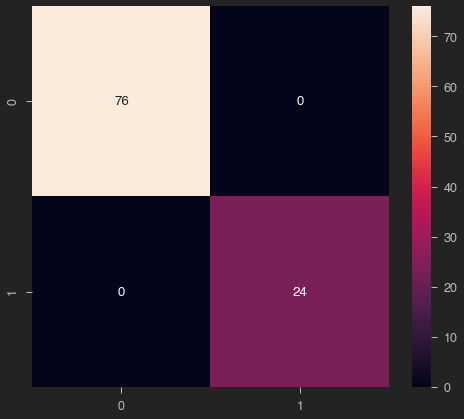

In [40]:
# Predicting the performance on train data
y_predict_train = NB_classifier.predict(X_train)
y_predict_train
cm = confusion_matrix(y_train, y_predict_train)
sns.heatmap(cm, annot = True)

<AxesSubplot:>

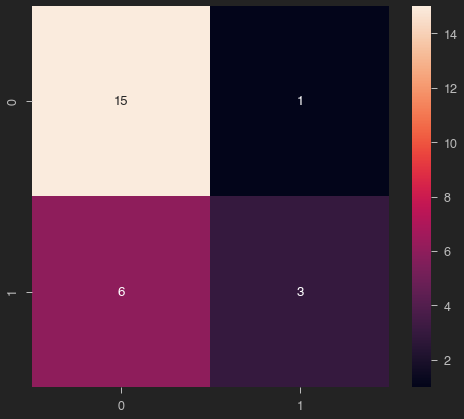

In [41]:
# Predicting the Test set results
y_predict_test = NB_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, annot = True)

In [42]:
# classification report
print(classification_report(y_test, y_predict_test))

              precision    recall  f1-score   support

           0       0.71      0.94      0.81        16
           1       0.75      0.33      0.46         9

    accuracy                           0.72        25
   macro avg       0.73      0.64      0.64        25
weighted avg       0.73      0.72      0.69        25



### Appendix 1. Understand the Theory and Intuition Behind Naive Bayes Classifiers

<img src="PPT/Naive_Bayes_Classifiers_1.png" width="1000">
<img src="PPT/Naive_Bayes_Classifiers_2.png" width="1000">
<img src="PPT/Naive_Bayes_Classifiers_3.png" width="1000">
<img src="PPT/Naive_Bayes_Classifiers_4.png" width="1000">
<img src="PPT/Naive_Bayes_Classifiers_5.png" width="1000">
<img src="PPT/Naive_Bayes_Classifiers_6.png" width="1000">
<img src="PPT/Naive_Bayes_Classifiers_7.png" width="1000">

Source: https://www.coursera.org/projects/resume-selector-using-naive-bayes by Ryan Ahmed - Adjunct Professor

***End of Page***